In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

# Lecture 3: Unconstrained optimization: Direct search methods

## Optimization problem to be studied

We will start studying functions of multiple variables by studying unconstrained optimization problems
$$
\begin{align}
\min \quad &f(x)\\
\text{s.t.}\quad &x\in \mathbb R^n
\end{align}  
$$

As an example, we study the optimization problem
$$
\begin{align}
\min \quad & (x_1-10)^2+(x_2+5)^2+x_1^2\\
\text{s.t.}\quad &x_1,x_2\in\mathbb R
\end{align}  
$$
This problem is unconstrained, because there are no constraints.

## Optimality conditions
(*Necessary condition*) Let $f$ be twice differentiable at $x^*\in\mathbb R^n$. If $x^*$ is a local minimizer, then $\nabla f(x^*)=0$ and the Hessian matrix $H(x^*)$ is positively semidefinite.

<a href="https://en.wikipedia.org/wiki/Hessian_matrix">What is a Hessian matrix?</a>

<a href="https://en.wikipedia.org/wiki/Definiteness_of_a_matrix">What means definiteness for matrices?</a>



(*Sufficient condition*) Let $f$ be twice **continuously** differentiable at $x^*\in\mathbb R^n$. If $\nabla f(x^*)=0$ and $H(x^*)$ is positively definite, then $x^*$ is a **strict** local minimizer.

When $\nabla f(x^*)=0$, then $x^*$ is said to be a **critical point**.

Let's consider our example problem:

$\nabla \left [(x_1-10)^2+(x_2+5)^2+x_1^2\right] = (2x_1-20+2x_1,2x_2+10)$

$=(4x_1-20,2x_2+10)=0 \iff x=(5,-5)$

By the sufficient condition, $(5,-5)$ is a strict local minimizer. (...*verify that $H(x)$ is positive definite*) 

Now we need to define a function in Python that evaluates that function. That is, we define a two-variable function 
$$f:(x_1,x_2)\to (x_1-10)^2+(x_2+5)^2+x_1^2$$

In [2]:
def f_simple(x):
    return (x[0] - 10.0)**2 + (x[1] + 5.0)**2 + x[0]**2


Now we can call that function

In [3]:
print("At point (3,-8) the value of the function is ",f_simple([3,-8]))


At point (3,-8) the value of the function is  67.0


In [4]:
print("At point (5,-5) the value of the function is ",f_simple([5,-5]))


At point (5,-5) the value of the function is  50.0


We can also plot that function

In [5]:
import numpy as np
from pylab import meshgrid
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_2d_function(lb1,lb2,ub1,ub2,f):
    x = np.arange(lb1,ub1,0.5) # divides the interval [lb1,ub1] into set of equally divided points 
    y = np.arange(lb2,ub2,0.5) # divides the interval [lb2,ub2] into set of equally divided points
    X,Y = meshgrid(x, y) # grid of points (x_i, y_j)
    Z = [f([x,y]) for (x,y) in zip (X,Y)] # evaluation of the function f on the grid
    Z = np.asarray(Z) # to convert input to an array.
    fig = plt.figure() # initializes figure
    ax = fig.gca(projection='3d') # 3D
    surf = ax.plot_surface(X, Y, Z) # surface plot of f
    return plt


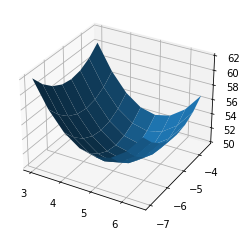

In [6]:
plot_2d_function(3,-7,7,-3,f_simple).show() # plot f when 3<x1<7 and -7<x2<-3


# Direct search methods

Direct search methods (also called pattern search methods) just rely on the function values to find a (local) optimum. Direct search methods consist of a set of  
1. **exploratory moves** that acquire information about the function $f$ in the neighbourhood of the current solution $x$, and
2. **pattern moves** that attempt to **speed up** the search using the information acquired in the exploratory moves (e.g., moving in the direction that found in the exploratory moves).

## Iterative approach

* At each iteration $k$ we have the current approximation of the optimal solution $x_k$ and a search pattern to find the next apprximation 


*   $x_{k+1} = x_k + \alpha_k d_k$, where


*             $\alpha_k > 0$ : step lenght
*             $d_k$ : search direction

## Simplest method: Coordinate descent
Optimize function towards each coordinate direction separately, **does not utilize pattern moves**.

![alt text](images/coordinate_descent.png "Coordinate descent")

$f(x)=2x_1^2+2x_1x_2+x_2^2+x_1-x_2$

* Slow convergence, especially when the level curves of the function are not along any of the coordinate axes 


## The idea of the pattern search

![alt text](images/pattern_search.jpg)


## Hooke&Jeeves (1961)

**input:** a minimum step length $L>0$, initial step length $\epsilon_0$, constant $0<\delta<1$ for reducing the step length, exploratory step multiplier $\gamma>1$, and starting solution $x_0$  
**output:** an approximation of a local optimum (no guarantees of quality in general cases)  
```
set epsilon as the initial step length epsilon0
set x as the starting solution
while epsilon is greater than L:
    for each coordinate direction i:
        find the smallest of function values by incrementing and reducing the 
        variable value in that coordinate by epsilon, let this value be xi*
    if x is the same as (x1*,...,xn*):
        reduce epsilon to delta*epsilon
```

``` 
     else:
        if the value of f at (x1*,...,xn*) is smaller than at x + gamma*((x1*,...,xn*)-x):
            set x as (x1*,...xn*)
        else:
            set x as x + gamma*((x1*,...,xn*)-x)
return x
```

Thus, the exploratory step of Hooke&Jeeves is performed by incrementing and reducing the variable to each coordinate direction and the pattern move is just a multiplication of the exploratory move.

![alt text](images/hooke&Jeeves.svg "Hooke&Jeeves")


In [7]:
import copy #Copying vectors
import numpy as np #Import vector calculus and much more!
def hookejeeves(L,epsilon0,delta,gamma,x0,f):
    #Set up the initial values
    epsilon = epsilon0
    x = np.array(x0)
    #Loop while step length epsilon is greater than L:
    while epsilon>L:
        #our exploratory move is initially [0,..,0]
        xtest = np.zeros(len(x))
        for coordinate in range(len(x)):
            #First points to be explored are the all x, to be changed
            exp_points = [copy.copy(x) for _ in range(3)] #points to be explored : [x, x, x]
            #Change exp_points[0] and exp_points[1] to reflect
            #moving along the coordinate
            exp_points[0][coordinate]-=epsilon 
            exp_points[1][coordinate]+=epsilon 
            #Assign the function values given by exp_points to a list
            f_exp_points = [f(exp_point) for exp_point in exp_points]
            #pick the smallest one of them
            min_value = min(f_exp_points)
            #The exploratory move to the coordinate direction is given by the
            #move giving the smallest value of f
            xtest[coordinate] = exp_points[f_exp_points.index(min_value)][coordinate] #The coordinate value is the one where the minimum is attained
        #If no move at all, then reduce the exploratory move step size
        if all(xtest==x):
            epsilon = delta*epsilon
        else:
            #if exploratory move is better than pattern move
            if f(xtest)<f(x+gamma*(xtest-x)):
                #...set x as the exploratory move
                x = xtest
            else:
                #Otherwise we take the pattern move
                x = x+gamma*(xtest-x)
    return x

In [8]:
L = 0.001
epsilon0 = 1
delta = 0.1
gamma = 2.0
start = [2.0,3.0]
#%timeit hookejeeves(L,epsilon0,delta,gamma,x0,f_simple)
x = hookejeeves(L,epsilon0,delta,gamma,start,f_simple); print("Optimal solution is " + str(x))

Optimal solution is [ 5. -5.]


### How does it actually work?

Let us define a function that can plot a set of steps:

In [9]:
import matplotlib.pyplot as plt

def plot_2d_steps(steps,start):
    myvec = np.array([start]+steps).transpose()
    plt.plot(myvec[0,],myvec[1,],'ro') # plotting only for problems with 2 variables
    for label,x,y in zip([str(i) for i in range(len(steps)+1)],myvec[0,],myvec[1,]):
        plt.annotate(label,xy = (x, y))
    return plt 

Now we need to save the steps of the algorithm. For that, let us modify the algorithm slightly:

In [10]:
import copy #Copying vectors
import numpy as np #Import vector calculus and much more!
def hookejeeves_savesteps(L,epsilon0,delta,gamma,x0,f):
    epsilon = epsilon0
    x = np.array(x0)
    steps = []
    while epsilon>L:
        xtest = np.zeros(len(x))
        # exploratory move
        for coordinate in range(len(x)):
            exp_points = [copy.copy(x) for _ in range(3)] #points to be explored
            exp_points[1][coordinate]-=epsilon
            exp_points[2][coordinate]+=epsilon
            f_exp_points = [f(exp_point) for exp_point in exp_points]
            min_value = min(f_exp_points)
            xtest[coordinate] = exp_points[f_exp_points.index(min_value)][coordinate] #The coordinate value is the one where the minimum is attained
        if all(xtest==x):
            # exploratory move is zero
            epsilon = delta*epsilon
            print(epsilon)
        else:
            # check if pattern move helps
            if f(xtest)<f(x+gamma*(xtest-x)):
                x = xtest
            else:
                x = x+gamma*(xtest-x)
            steps.append(x)
            #print(x)
    return x,steps

In [11]:
L = 0.001
epsilon0 =  0.3
delta = 0.1
gamma = 2
start = [2,3]
(x,steps) = hookejeeves_savesteps(L,epsilon0,delta,gamma,start,f_simple)
print(x)
print(len(steps))
print(f_simple(x))

0.03
0.003
0.00030000000000000003
[ 5. -5.]
11
50.0


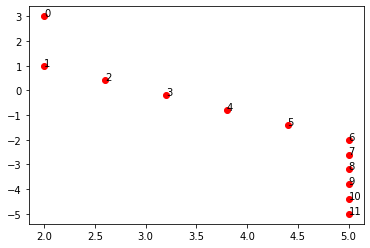

In [12]:
plot_2d_steps(steps,start).show()

## The role of the step length 
The above implementation uses a fixed step length. It is easier to implement but not as efficient if the step length would be optimized by using a line search. The difference is illustrated in the figures below.

Fixed                    |Optimized
:-----------------------:|:----------------------------:
![](images/hj_fixed.png) | ![](images/hj_optimized.png)

**Note: You can implement a version optimizing the step length by line search, e.g., when solving future excercises**


## Powell's method (1964)

Powell's method is similar to Hooke&Jeeves, but the first step in exploratory moves is taken to the direction of the last pattern move. This speeds up the convergence in most cases (**highly depending on how the step size is computed!**).


In [13]:
import copy
import numpy as np
def powell(L,epsilon0,delta,gamma,x0,f):
    epsilon = epsilon0
    exp_direction = np.array([0,1])
    x = np.array(x0)
    while epsilon>L:
        exp_direction=epsilon*exp_direction # to take steps of length epsilon
        #Comparing among exploratory points to first exploratory direction:
        if f(x+exp_direction)<f(x):
            exp_step1=exp_direction
        elif f(x-exp_direction)<f(x):
            exp_step1=-exp_direction
        else:
            exp_step1 = np.zeros(2)
        #The following only works in 2d!!
        exp_direction2 = np.array([exp_direction[1],-exp_direction[0]]) # conjugate directions
        if f(x+exp_direction2)<f(x):
            exp_step2=exp_direction2
        elif f(x-exp_direction2)<f(x):
            exp_step2=-exp_direction2
        else:
            exp_step2 = np.zeros(2)
        if all(exp_step1+exp_step2==0):
            epsilon = delta*epsilon
        else:
            if f(x+(exp_step1+exp_step2))<f(x+gamma*(exp_step1+exp_step2)):
                x = x+(exp_step1+exp_step2)
            else:
                x = x+gamma*(exp_step1+exp_step2)
            exp_direction = epsilon*(exp_step1+exp_step2)/np.linalg.norm(exp_step1+exp_step2)
    return x

In [14]:
L = 0.001
epsilon0 = 1.
delta = 0.1
gamma = 2.0
start = [2.,3.]
#%timeit powell(L,epsilon0,delta,gamma,x0,f_simple)
x = powell(L,epsilon0,delta,gamma,start,f_simple)
print("Optimal solution is " + str(x))

Optimal solution is [ 5.00000029 -5.00000031]


### How does it actually work?

Let us again modify the algorithm slightly:

In [15]:
import copy
import numpy as np
def powell_savesteps(L,epsilon0,delta,gamma,x0,f):
    epsilon = epsilon0
    exp_direction = np.array([0,1])
    x = np.array(x0)
    steps = []
    while epsilon>L:
        exp_direction=epsilon*exp_direction
        #Comparing among exploratory points to firtst exploratory direction:
        if f(x+exp_direction)<f(x):
            exp_step1=exp_direction
        elif f(x-exp_direction)<f(x):
            exp_step1=-exp_direction
        else:
            exp_step1 = np.zeros(2)
        #The following only works in 2d!!
        exp_direction2 = np.array([exp_direction[1],-exp_direction[0]])
        if f(x+exp_direction2)<f(x):
            exp_step2=exp_direction2
        elif f(x-exp_direction2)<f(x):
            exp_step2=-exp_direction2
        else:
            exp_step2 = np.zeros(2)
        if all(exp_step1+exp_step2==0):
            epsilon = delta*epsilon
            print(epsilon)
        else:
            if f(x+(exp_step1+exp_step2))<f(x+gamma*(exp_step1+exp_step2)):
                x = x+(exp_step1+exp_step2)
            else:
                x = x+gamma*(exp_step1+exp_step2)
            steps.append(x)
            exp_direction = (exp_step1+exp_step2)/np.linalg.norm(exp_step1+exp_step2)
            #print(x)
    return x,steps

In [16]:
L = 0.001
epsilon0 = 0.3
delta = 0.1
gamma = 2
start = [2,3]
(x,steps) = powell_savesteps(L,epsilon0,delta,gamma,start,f_simple)
print(x)
print(len(steps))

0.03
0.003
0.00030000000000000003
[ 5.         -5.00146069]
17


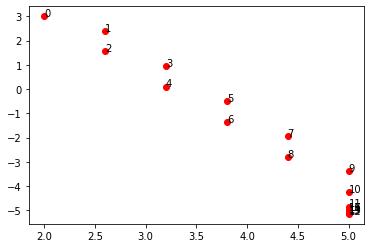

In [17]:
plot_2d_steps(steps,start).show()

Another example
$$
\begin{align}
\min \quad & (x_1-2)^4+(x_1 - 2x_2)^2\\
\text{s.t.}\quad &x_1,x_2\in\mathbb R
\end{align}  
$$
Optimal solution clearly is $x^*=(2,1)^T$

In [18]:
def f_simple2(x):
    return (x[0] - 2.0)**4 + (x[0] - 2.0*x[1])**2

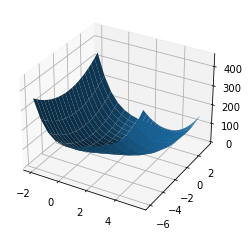

In [19]:
plot_2d_function(-2,-6,6,4,f_simple2).show()

In [20]:
# Hooke & Jeeves
L = 0.0001
epsilon0 = .8
delta = 0.1
gamma = 2
start = [-1.,3.]
(x,steps) = hookejeeves_savesteps(L,epsilon0,delta,gamma,start,f_simple2)
print(x)
print(len(steps))

0.08000000000000002
0.008000000000000002
0.0008000000000000003
8.000000000000003e-05
[1.916  0.9576]
90


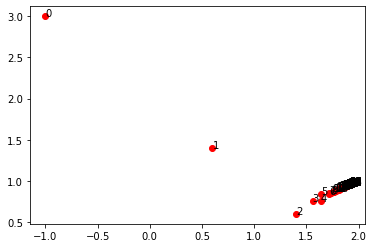

In [21]:
plot_2d_steps(steps,start).show()

In [22]:
# Powell
L = 0.0001
epsilon0 = .8
delta = 0.1
gamma = 2.
start = [-1.,3.]
(x,steps) = powell_savesteps(L,epsilon0,delta,gamma,start,f_simple2)
print(x)
print(len(steps))

0.08000000000000002
0.008000000000000002
0.0008000000000000003
8.000000000000003e-05
[1.94316485 0.97120742]
21


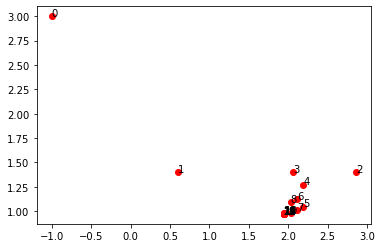

In [23]:
plot_2d_steps(steps,start).show()

Just another example
$$
\begin{align}
\min \quad & x_1^2+2x_1x_2+x_2^2+x_1-x_2\\
\text{s.t.}\quad &x_1,x_2\in\mathbb R
\end{align}  
$$
Optimal solution is $x^*=(-1,1.5)^T$

In [24]:
def f_simple3(x):
    return 2.0*x[0]**2 + 2.0*x[0]*x[1] + x[1]**2 + x[0] - x[1]
# opt = (-1,1.5)

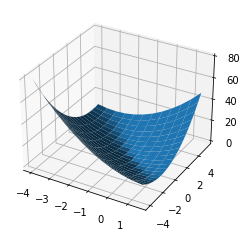

In [25]:
plot_2d_function(-4,-4,2,6,f_simple3).show()


In [26]:
print(f_simple3([-1.,1.4]))
print(f_simple3([-.9,1.5]))
print(f_simple3([-1.,1.5]))


-1.24
-1.23
-1.25


In [27]:
# Hooke & Jeeves
L = 0.001
epsilon0 = 1.
delta = 0.1
gamma = 2
start = [-2.0,3.0]
(x,steps) = hookejeeves_savesteps(L,epsilon0,delta,gamma,start,f_simple3)
print(x)
print(len(steps))


0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
[-1.   1.5]
18


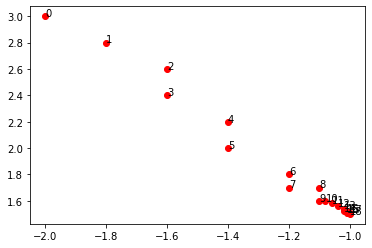

In [28]:
plot_2d_steps(steps,start).show()


In [29]:
L = 0.001
epsilon0 = 1.
delta = 0.1
gamma = 2.0
start = [-2.,3.]
(x,steps) = powell_savesteps(L,epsilon0,delta,gamma,start,f_simple3)
print(x)
print(len(steps))


0.1
0.010000000000000002
0.0010000000000000002
0.00010000000000000003
[-1.00060323  1.50036488]
23


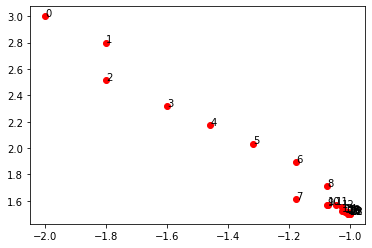

In [30]:
plot_2d_steps(steps,start).show()


## Nelder Mead method (by J. Nelder & R. Mead in 1965)

A direct search method based on a simplex, i.e., $n+1$ points in $n$-dimensional space. The points for a simplex are iteratively updated by replacing the worst point based on the objective function value. Further information and illustration can be found e.g. in <a href="https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method">Nelder-Mead</a>

## Nice review and wrap-up papers about the direct search methods:

* https://www.cs.wm.edu/~va/research/sirev.pdf
* https://www.sciencedirect.com/science/article/pii/S0377042700004234 